<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARMA</font></b></strong>

**Modelos de Média Móvel Auto-Regressiva (ARMA - Auto Regressive Moving Average)**

O modelo ARMA é simplesmente a fusão entre os modelos AR (p) e MA (q).
 
Os modelos AR (p) tentam explicar o momento e os efeitos médios da reversão frequentemente observados nos mercados (efeitos dos participantes do mercado).

Os modelos MA (q) tentam capturar os efeitos de choque observados em termos de ruído branco. Estes efeitos de choque podem ser considerados eventos inesperados que afetam o processo de observação, p, como ganhos repentinos, guerras, ataques, etc.

O modelo ARMA tenta capturar esses dois aspectos ao modelar séries temporais. O modelo ARMA não leva em consideração o agrupamento de volatilidade, um fenômeno empírico essencial de muitas séries temporais financeiras que discutiremos mais adiante.

Modelo ARMA(1,1) é representado como:

x(t) = a*x(t-1) + b*e(t-1) + e(t)

Onde e(t) é o ruído branco com E [e(t)] = 0

Um modelo ARMA geralmente requer menos parâmetros que um modelo AR (p) ou um modelo MA (q) individual. Ou seja, é redundante em seus parâmetros.

Criaremos um modelo ARMA neste notebook.

In [3]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date, timedelta

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#%matplotlib inline

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

sklearn    : 1.1.1
matplotlib : 3.3.4
statsmodels: 0.12.2
numpy      : 1.19.5
pandas     : 1.2.4
sys        : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
scipy      : 1.6.2



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [5]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [6]:
# Dados
dataframe.head()

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0


In [7]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['Quantidade']

In [8]:
# Random seed 
np.random.seed(7)

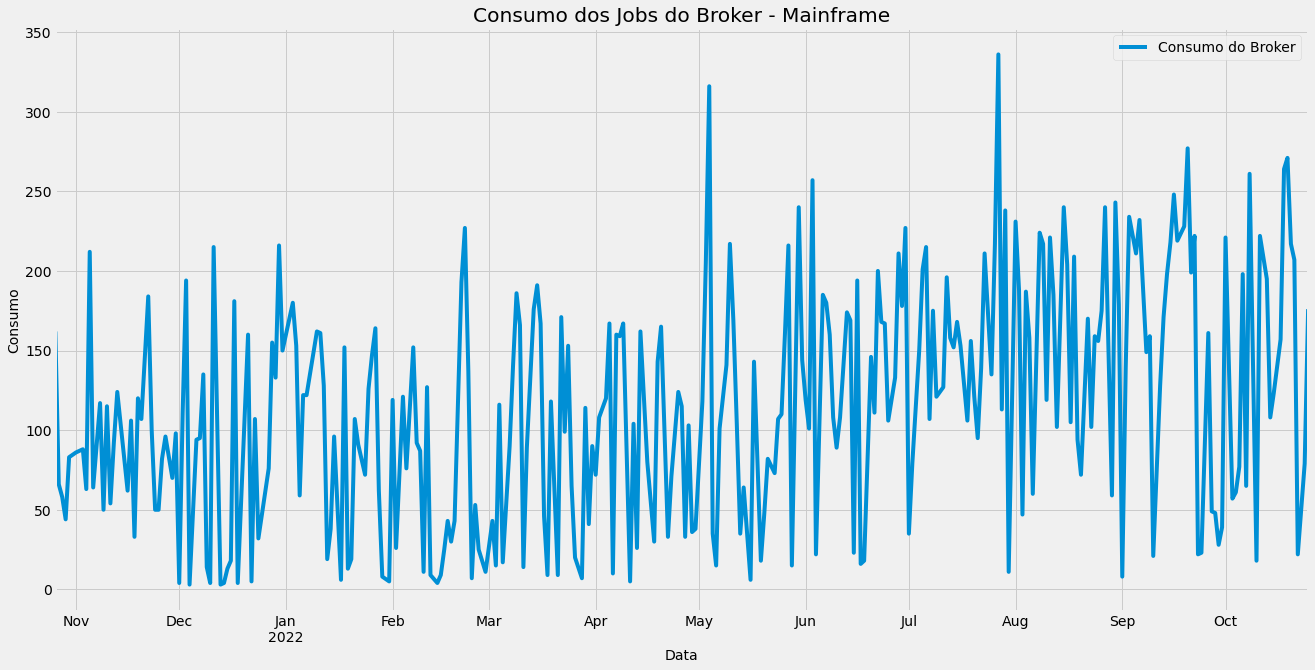

In [9]:
# Plot
target.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [10]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

273 92


In [11]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo ARMA

Dada uma série temporal de dados Xt, o modelo ARMA é uma ferramenta para entender e, talvez, prever valores futuros nesta série. A parte AR envolve a regressão da variável com seus próprios valores defasados (isto é, passados). A parte MA envolve modelar o termo de erro como uma combinação linear de termos de erro que ocorrem contemporaneamente e em vários momentos no passado. O modelo é geralmente chamado de modelo ARMA (p, q), em que p é a ordem da parte AR e q é a ordem da parte MA.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html

In [48]:
# Cria o modelo
modelo_arma = ARMA(treino, order = (4, 3))

In [49]:
# Treina o modelo
modelo_arma_fit = modelo_arma.fit(method = 'mle', disp = False)

In [50]:
# Sumário do modelo
modelo_arma_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Quantidade   No. Observations:                  273
Model:                     ARMA(4, 3)   Log Likelihood               -1492.321
Method:                           mle   S.D. of innovations             56.801
Date:                Thu, 27 Oct 2022   AIC                           3002.642
Time:                        19:47:17   BIC                           3035.128
Sample:                    10-26-2021   HQIC                          3015.683
                         - 07-25-2022                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              104.4194     14.587      7.158      0.000      75.829     133.009
ar.L1.Quantidade    -0.1249      0.068     -1.847      0.065      -0.258       0.008
ar.L2.Quantidade     0.4368      0.036     12.103      0.000       0.366       0.508
ar.L3.Quantidade     0.8752      0.032     27.237      0.000       0.812       0.938
ar.L4.Quantidade    -0.2176      0.065     -3.327      0.001      -0.346      -0.089
ma.L1.Quantidade     0.4360      0.034     12.928      0.000       0.370       0.502
ma.L2.Quantidade    -0.3315      0.041     -8.143      0.000      -0.411      -0.252
ma.L3.Quantidade    -0.9563      0.031    -31.282      0.000      -1.016      -0.896
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6925           -0.7440j            1.0164           -0.3693
AR.2           -0.6925           +0.7440j            1.0164            0.3693
AR.3            1.0121           -0.0000j            1.0121           -0.0000
AR.4            4.3944           -0.0000j            4.3944           -0.0000
MA.1            1.0457           -0.0000j            1.0457           -0.0000
MA.2           -0.6962           -0.7179j            1.0000           -0.3726
MA.3           -0.6962           +0.7179j            1.0000            0.3726
-----------------------------------------------------------------------------
"""

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

In [51]:
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
print("inicio: ", inicio, " fim : ", fim, "n dias: ", td)

inicio:  2022-07-25 00:00:00  fim :  2022-10-25 00:00:00 n dias:  92 days, 0:00:00


In [52]:
# Previsões com o modelo
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
arma_predict = modelo_arma_fit.predict(start = inicio, 
                                       end = fim,
                                       dynamic = False)

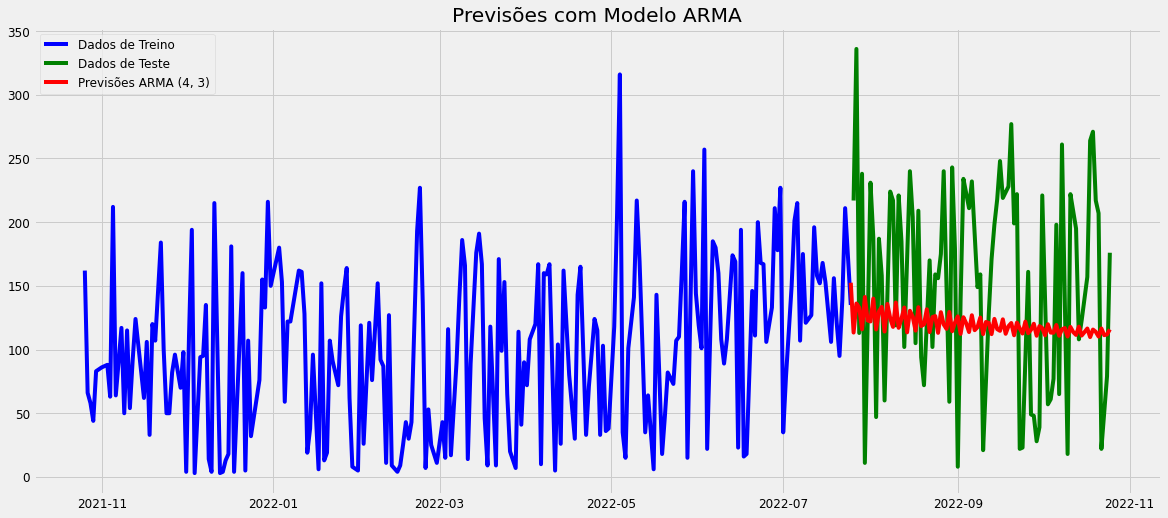

In [53]:
# Plot
rcParams['figure.figsize'] = 18, 8
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arma_predict, label = 'Previsões ARMA (4, 3)', color = 'red')
plt.title('Previsões com Modelo ARMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

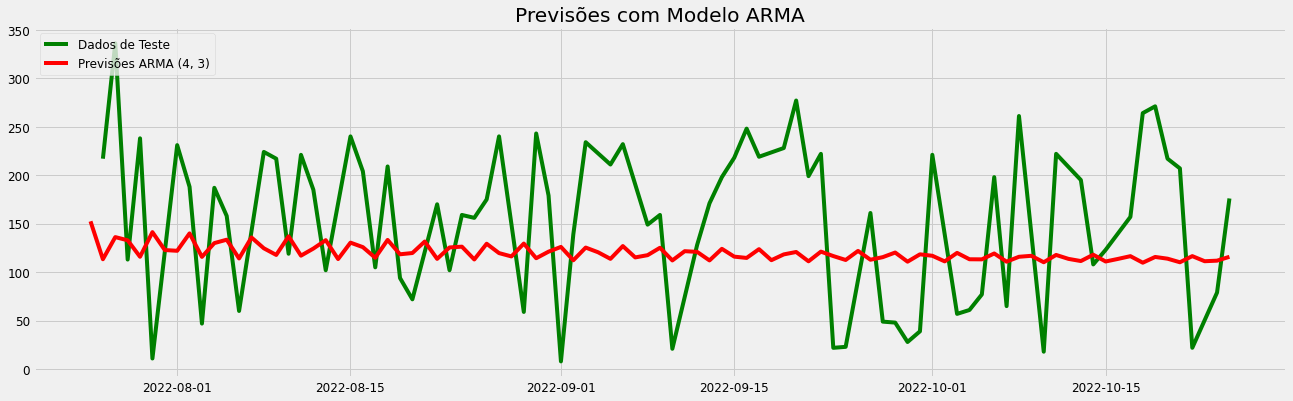

In [54]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arma_predict, label = 'Previsões ARMA (4, 3)', color = 'red')
plt.title('Previsões com Modelo ARMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [55]:
# Avaliando a performance com dados de teste 
arma_results = performance(teste, arma_predict)

MSE das previsões é 6823.8258
RMSE das previsões é 82.6065
MAPE das previsões é 98.241


Vamos executar alguns diagnósticos para avaliar o modelo.

Começamos criando uma função com os Plots ACF e PACF, além dos resíduos.

In [36]:
# Função
def tsplot(y, lags = None, figsize = (12, 8), style = 'bmh'):
    
    # Se a série não for do tipo pd.Series, fazemos a conversão
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # Criamos os plots
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Plots Para Análise de Séries Temporais')
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax, alpha = 0.05)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax, alpha = 0.05)
        sm.qqplot(y, line = 's', ax = qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams = (y.mean(), y.std()), plot = pp_ax)

        plt.tight_layout()
    return

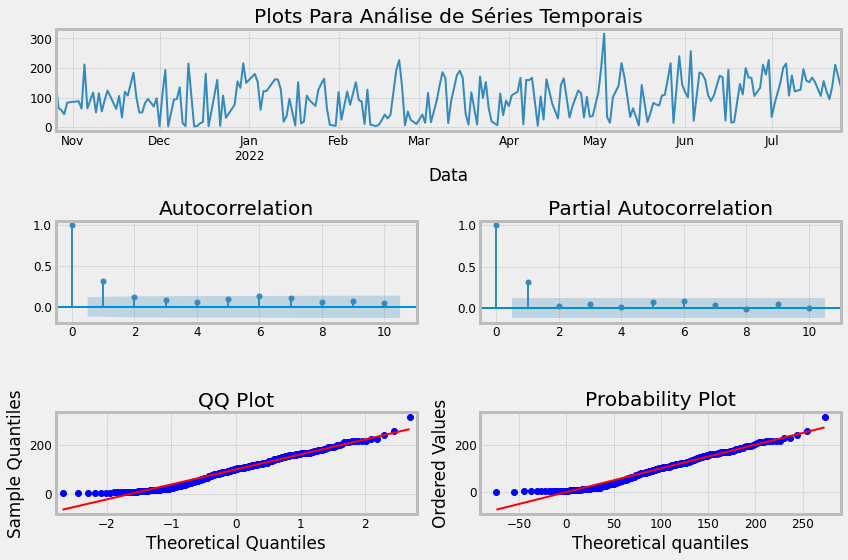

In [37]:
# Executa a função com dados de treino
tsplot(treino, lags = 10)

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [38]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arma_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.38379980  -  Os resíduos parecem normalmente distribuídos.


In [39]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arma_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.75338552]


In [39]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arma_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [2.26087689e-46]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto, um modelo ARMA (1,0) não fornece um bom ajuste do modelo.

Ajustes dos valores de p e q

Para ajustar os dados a um modelo ARMA, usamos o Akaike Information Criterion (AIC) em um subconjunto de valores para p, q para encontrar o modelo com o mínimo AIC e, em seguida, aplicamos o teste de Ljung-Box para determinar se um bom ajuste foi alcançado para valores particulares de p, q. Se o valor-p do teste for maior que a significância requerida, podemos concluir que os resíduos são independentes e ruído branco.

In [40]:
# Vamos tentar encontrar os melhores valores de p e q
# O AIC deve ser o menor possível

warnings.simplefilter("ignore")

# Valores iniciais
melhor_aic = np.inf 
melhor_order = None
melhor_modelo = None

# Valores para testar a melhor combinação order = (i, j)
valores_para_order = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Loop
for i in valores_para_order:
    for j in valores_para_order:
        try:
            tmp_mdl = ARMA(treino, order = (i, j)).fit(disp = False)
            tmp_aic = tmp_mdl.aic
            if tmp_aic < melhor_aic:
                melhor_aic = tmp_aic
                melhor_order = (i, j)
                melhor_modelo = tmp_mdl
        except: continue

# Print
print('\nMelhor Valor de AIC: %6.2f | order: %s'%(melhor_aic, melhor_order))
print('\nMelhor Modelo:', melhor_modelo.summary())


Melhor Valor de AIC: 3002.64 | order: (4, 3)

Melhor Modelo:                               ARMA Model Results                              
Dep. Variable:             Quantidade   No. Observations:                  273
Model:                     ARMA(4, 3)   Log Likelihood               -1492.321
Method:                       css-mle   S.D. of innovations             56.800
Date:                Thu, 27 Oct 2022   AIC                           3002.642
Time:                        19:41:34   BIC                           3035.128
Sample:                    10-26-2021   HQIC                          3015.683
                         - 07-25-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              104.4200     14.587      7.159      0.000      75.830     133.010
ar.L1.Quantidade    -0.1249      0.068     -1.847  

Reduziu o erro do nosso modelo. 

RMSE:

modelo11_modelo12_modelo13__modelo14_modelo 15

_7.6327____ 8.7714____5.1253____4.9166____3.5966

As mensagens de warning acima indicam que para algumas combinações de order (i, j) o modelo não consegue nem mesmo convergir. Por fim, a melhor combinação foi a que escolhemos no início e que apresenta a melhor performance: order: (5, 5).

Será que conseguimos fazer melhor do que isso? Você não vi nada ainda! Além do Modelo ARMA, confira os modelos que vamos criar nas próximas aulas:

- Modelo ARIMA
- Modelo SARIMA
- Modelo Triple Exponential Smoothing

- Modelo LSTM (Deep Learning)
- Modelo Stacked LSTM (Deep Learning)
- Modelo Bidirectional LSTM (Deep Learning)
- Modelo Convolutional Neural Network (Deep Learning)

Estudaremos ainda como usar Grid Search para encontrar os melhores valores dos parâmetros p, d e q.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim